# Pretrained H&E classifier
Training set: central patches from Y-pos vs Y-neg images.  
No attempt to distinguish background, stroma, tumor.  
Retrain VGG.  
Expect no classification.

## Classify patches
Use VGG. 


In [1]:
import time
import os
#  os.environ['CUDA_VISIBLE_DEVICES'] = "0"   # turns off GPU?
import glob
#import cv2 # OpenCV-Python
#from PIL import Image
#Image.MAX_IMAGE_PIXELS = None
import numpy as np
import json
from tensorflow import keras
import keras.layers as kl
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

numpy==1.22.1
json==2.0.9
keras.api._v2.keras==2.7.0
pandas==1.4.0


In [2]:
DIR_IMAGES_IN = "/home/jrm/Martinez/images/HEcenterpatch/"  
PATCH_SIZE=224  # matches VGG
DIR_MODELS = "/home/jrm/Martinez/models/"
FILE_MODEL = "HE_Filter.026"
filepath=DIR_MODELS+FILE_MODEL
print("Will overwrite model at "+filepath)
BATCH_SIZE = 32
IMG_SIZE = (PATCH_SIZE,PATCH_SIZE)
CHANNELS = 3

Will overwrite model at /home/jrm/Martinez/models/HE_Filter.026


In [3]:
train_dir = os.path.join(DIR_IMAGES_IN, 'train')
valid_dir = os.path.join(DIR_IMAGES_IN, 'valid')
train_dataset = keras.utils.image_dataset_from_directory(
    train_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)
valid_dataset = keras.utils.image_dataset_from_directory(
    valid_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)


Found 30892 files belonging to 2 classes.
Found 7722 files belonging to 2 classes.


In [4]:
# Normalize color channel ints to floats (0,1)
# See https://www.tensorflow.org/tutorials/load_data/images

normalization_layer = kl.Rescaling(1.0/255.0)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
valid_dataset = valid_dataset.map(lambda x, y: (normalization_layer(x), y))

In [5]:
iterator = valid_dataset.take(10)
for x in iterator:
    print(x[0].shape)
    print(x[1])

(32, 224, 224, 3)
tf.Tensor([1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 0 1 1 1 1 0 1 1 0 1 1], shape=(32,), dtype=int32)
(32, 224, 224, 3)
tf.Tensor([0 1 0 1 0 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1], shape=(32,), dtype=int32)
(32, 224, 224, 3)
tf.Tensor([0 1 1 1 1 1 0 1 0 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0], shape=(32,), dtype=int32)
(32, 224, 224, 3)
tf.Tensor([0 1 1 0 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1 1 1 0 0 1 1 1 0 1 1 1 1 0], shape=(32,), dtype=int32)
(32, 224, 224, 3)
tf.Tensor([1 1 1 0 1 1 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1], shape=(32,), dtype=int32)
(32, 224, 224, 3)
tf.Tensor([1 1 1 0 1 0 1 1 1 0 1 1 1 0 0 1 1 1 0 1 1 1 0 1 1 0 0 0 1 1 1 1], shape=(32,), dtype=int32)
(32, 224, 224, 3)
tf.Tensor([1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 0 0 1 1 1 1 0 1 1], shape=(32,), dtype=int32)
(32, 224, 224, 3)
tf.Tensor([1 0 1 0 1 1 1 1 1 0 1 0 1 1 0 1 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1], shape=(32,), dtype=int32)
(32, 224, 224, 3)
tf.Tensor([1 0

## VGG
https://keras.io/guides/transfer_learning/  
https://towardsdatascience.com/step-by-step-guide-to-using-pretrained-models-in-keras-c9097b647b29  

In [6]:
CLASSES = 2
#base_model = VGG16(weights='imagenet',include_top=False)  # top= classification layer
# optional: input_shape=(224, 224, 3)
#base_model.trainable = False
#inputs = keras.Input(shape=(PATCH_SIZE, PATCH_SIZE, CHANNELS))
#x = base_model(inputs, training=False)

#x = keras.layers.GlobalAveragePooling2D()(x)
#outputs = keras.layers.Dense(CLASSES)(x)
#model = keras.Model(inputs, outputs)

#x = keras.layers.Flatten()(x)
#outputs = keras.layers.Dense(CLASSES)(x)
#model = keras.Model(inputs, outputs)

VGG = VGG16(weights='imagenet',include_top=False,input_shape=(PATCH_SIZE, PATCH_SIZE, CHANNELS))
VGG.trainable = False
model = keras.models.Sequential()
model.add(VGG)
model.add(kl.Flatten())
model.add(kl.Dense(16))
model.add(kl.Dropout(0.25))
model.add(kl.Dense(CLASSES,activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 16)                401424    
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 34        
                                                                 
Total params: 15,116,146
Trainable params: 401,458
Non-trainable params: 14,714,688
_________________________________________________________________


## Optimizer = SGD or ADAM ?
ADAM converges faster but SGD better in the long run.  
https://medium.com/geekculture/a-2021-guide-to-improving-cnns-optimizers-adam-vs-sgd-495848ac6008

In [7]:
model.compile(loss="sparse_categorical_crossentropy",
           optimizer="sgd",
           metrics=["accuracy"])
EPOCHS=10
start = time.time()
hist = model.fit(train_dataset,validation_data=valid_dataset,epochs=EPOCHS)
end = time.time()
print("Elapsed time:",end-start)

Epoch 1/10
966/966 [==============================] - 70s 70ms/step - loss: 0.5872 - accuracy: 0.7808 - val_loss: 0.4325 - val_accuracy: 0.8104
Epoch 2/10
966/966 [==============================] - 67s 69ms/step - loss: 0.4438 - accuracy: 0.7995 - val_loss: 0.4658 - val_accuracy: 0.7813
Epoch 3/10
966/966 [==============================] - 67s 69ms/step - loss: 0.4291 - accuracy: 0.8095 - val_loss: 0.4137 - val_accuracy: 0.8168
Epoch 4/10
966/966 [==============================] - 67s 70ms/step - loss: 0.4197 - accuracy: 0.8140 - val_loss: 0.4075 - val_accuracy: 0.8200
Epoch 5/10
966/966 [==============================] - 67s 70ms/step - loss: 0.4135 - accuracy: 0.8162 - val_loss: 0.4409 - val_accuracy: 0.8059
Epoch 6/10
966/966 [==============================] - 67s 70ms/step - loss: 0.4068 - accuracy: 0.8198 - val_loss: 0.3991 - val_accuracy: 0.8272
Epoch 7/10
966/966 [==============================] - 68s 70ms/step - loss: 0.4027 - accuracy: 0.8228 - val_loss: 0.4079 - val_accuracy:

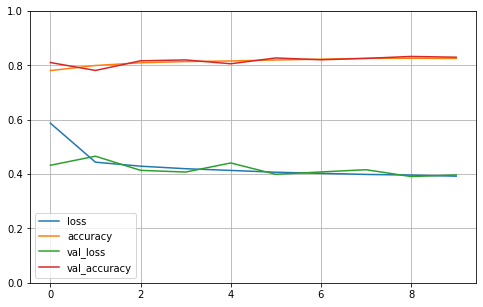

In [8]:
pd.DataFrame(hist.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0.0,1.0)
plt.show()

In [9]:
model.save(filepath)

INFO:tensorflow:Assets written to: /home/jrm/Martinez/models/HE_Filter.026/assets


Training set: 23977 Ypos, 6917 Yneg. Pos=0.7761  
Validation set: 5995 Ypos, 1729 Yneg. Pos= 0.7762  